# Alanine dipeptide: MSM and hdbMSM

### In this notebook we show the essentials to obtain the MSM and hdbMSM corresponding to a previously run alanine dipeptide simulation.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [2]:
import mdtraj as md

### Analysis

You can download both the trajectory file and its corresponding GROMACS gro file from [here](https://osf.io/2ujtg/?view_only=11824fcadefa4987bfb5a5dd64b6ad6f).

In [3]:
topfile = "data/alaTB.gro"
traj = md.load_xtc("data/alatb_n1_ppn24.xtc", \
                   top=topfile)

In [4]:
import pyemma
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from pyemma.util.contexts import settings

pyemma.__version__

'2.5.7'

Take backbone torsion angles as features for MSM discretization.

In [5]:
feat = coor.featurizer(topfile)

In [6]:
feat.add_backbone_torsions()

In [7]:
feat.describe()

['PHI 0 ALA 2', 'PSI 0 ALA 2']

In [8]:
X = feat.transform(traj)

Carry out discretization by using K-means clustering with k=150 cluster centers.

In [9]:
kmeans = coor.cluster_kmeans(X, k=200, stride=1, max_iter=1000)

In [10]:
kmeans.cluster_centers_[:10]

array([[-1.2846603 ,  2.8250265 ],
       [-1.7357235 , -0.2844571 ],
       [-2.620677  ,  2.8994446 ],
       [-2.2117348 , -3.0588727 ],
       [ 0.9829929 ,  0.7292961 ],
       [-2.5179386 , -0.26040876],
       [-1.9866999 ,  0.8852481 ],
       [-2.0508235 ,  2.8437288 ],
       [-1.401144  ,  2.432027  ],
       [-1.1371521 ,  0.03874312]], dtype=float32)

In [11]:
dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]

In [12]:
dtrajs

[array([122, 188,  63, ..., 186,   1,  13], dtype=int32)]

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


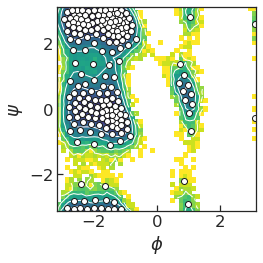

In [13]:
fig, ax = plt.subplots(figsize=(4,4))
h, xedges, yedges, im = ax.hist2d(X[:,0], X[:,1], bins=[np.linspace(-np.pi, np.pi, 50), \
                                                        np.linspace(-np.pi, np.pi, 50)], \
          cmap='viridis_r', norm=mpl.colors.LogNorm(), density=True)
ax.contour(-np.transpose(np.log(h)), extent=[xedges.min(), xedges.max(), yedges.min(), yedges.max()], \
                  linewidths=1,  colors='white')
ax.plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], lw=0, marker='o', mfc='w', mec='k')
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')
plt.tight_layout()

### Traditional MSM construction

In [14]:
lags = [1, 2, 5, 10, 20, 50]

its_fine = msm.its(dtrajs, lags=lags, errors=None)

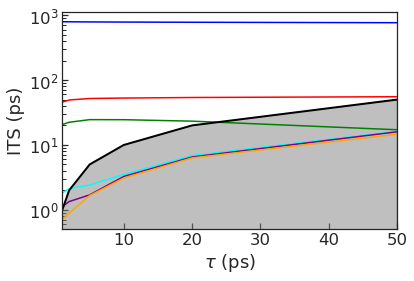

In [15]:
mplt.plot_implied_timescales(its_fine, show_mean=True, nits=6, \
                             ylog=True, units='ps', dt=1)
plt.ylabel('ITS (ps)')
plt.xlabel(r'$\tau$ (ps)')
sns.set_context('paper', font_scale=1.5)

From the implied timescales (ITS) shown in the plot above, we consider that the MSM is already converged for $\tau$=10 ps.

In [16]:
M = msm.bayesian_markov_model(dtrajs, 10, dt_traj='1 ps')

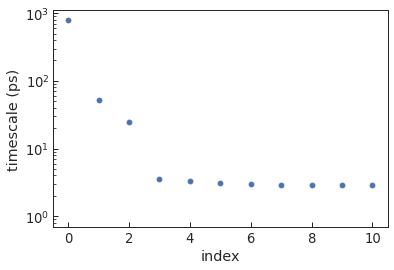

In [17]:
plt.plot(M.timescales(),linewidth=0,marker='o')
plt.xlabel('index')
plt.ylabel('timescale (ps)')
plt.xlim(-0.5,10.5)
plt.yscale('log')

Since there are three slow processes, let us lump the microstates into four macrostates by using PCCA+ spectral clustering. The resulting coarse-grained MSM is then validated by computing the corresponding Chapman-Kolmogorov test.

In [18]:
npcca = 4
M.pcca(npcca)

PCCA(P=array([[0.01696, 0.00079, ..., 0.00068, 0.     ],
       [0.00141, 0.02252, ..., 0.00522, 0.     ],
       ...,
       [0.0043 , 0.01865, ..., 0.00717, 0.     ],
       [0.     , 0.     , ..., 0.     , 0.07547]]),
   m=4)

In [19]:
pcca_sets = M.metastable_sets

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


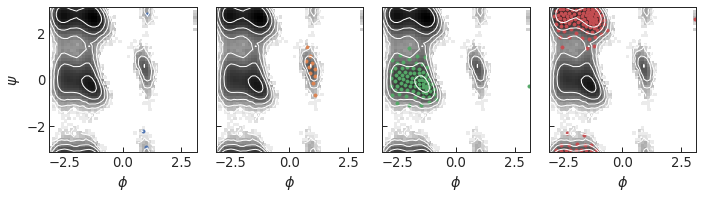

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True)
for i in range(4):
    h, xedges, yedges, im = ax[i].hist2d(X[:,0], X[:,1], bins=[np.linspace(-np.pi, np.pi, 50), \
                                                        np.linspace(-np.pi, np.pi, 50)], \
          cmap='binary', norm=mpl.colors.LogNorm(), density=True)
    ax[i].contour(-np.transpose(np.log(h)), extent=[xedges.min(), xedges.max(), yedges.min(), yedges.max()], \
                  linewidths=1,  colors='white')
for i in range(npcca):
    ax[i].scatter(kmeans.cluster_centers_[pcca_sets[i],0], kmeans.cluster_centers_[pcca_sets[i],1], color='C%g'%i, s=10)
[ax[i].set_xlabel('$\phi$') for i in range(4)]
ax[0].set_ylabel('$\psi$')
plt.tight_layout()

In [21]:
eigvec = M.eigenvectors_left()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

first eigenvector is one: False (min=-0.015118705304835174, max=0.0172186345499371)


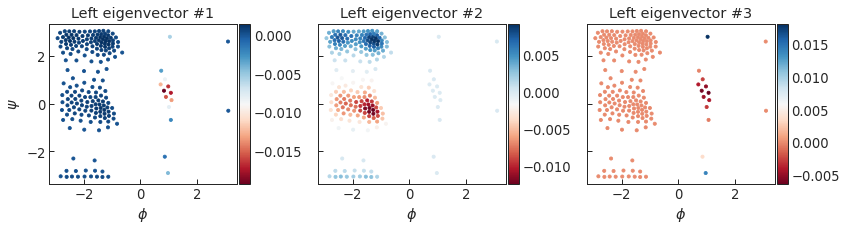

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 3, figsize=(12,3.45), sharex=True, sharey=True)
for i in range(3):
    sc = ax[i].scatter(kmeans.clustercenters[:,0],kmeans.clustercenters[:,1],\
                c=eigvec[i+1], s=10, cmap='RdBu')
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='6%', pad=0.03)
    fig.colorbar(sc, cax=cax, orientation='vertical')
    ax[i].set_title('Left eigenvector #%g'%(i+1))
[ax[i].set_xlabel('$\phi$') for i in range(3)]
ax[0].set_ylabel('$\psi$')
plt.tight_layout()

In [23]:
np.shape(eigvec)

(200, 200)

(<Figure size 720x720 with 16 Axes>,
 array([[<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='lag time (ps)', ylabel='probability'>,
         <AxesSubplot:xlabel='lag time (ps)'>,
         <AxesSubplot:xlabel='lag time (ps)'>,
         <AxesSubplot:xlabel='lag time (ps)'>]], dtype=object))

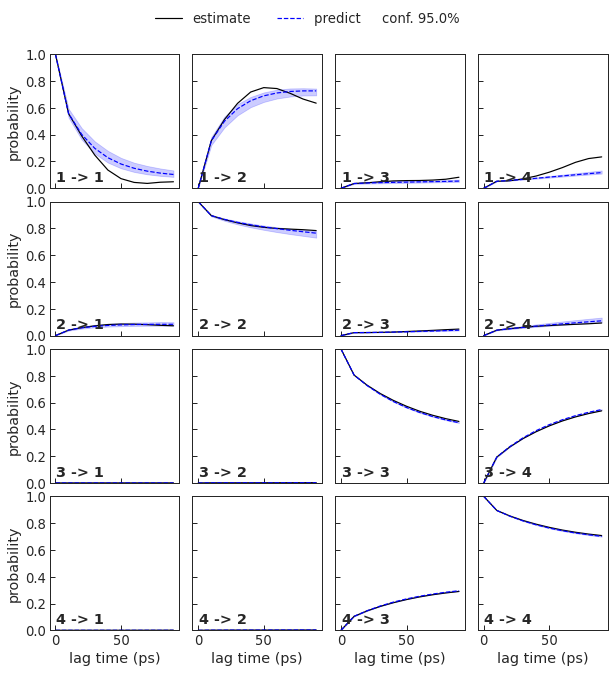

In [24]:
pyemma.plots.plot_cktest(M.cktest(4), units='ps', dt=1)

### hdbMSM: MSM construction exploting density-based clustering

In [25]:
import hdbscan
import copy

Shift angles to avoid periodicity issues when clustering with HDBSCAN.

In [26]:
def shift(X):
    Xshift = copy.deepcopy(X)
    for i in range(len(Xshift)):
        if Xshift[i,1] < -2:
            Xshift[i,1] += 2*np.pi
        if Xshift[i,0] > 2:
            Xshift[i,0] -= 2*np.pi
    return Xshift

In [27]:
Xshift = shift(X)
np.min(Xshift[:,1]), np.min(X[:,1])

(-1.9932764, -3.1415923)

Apply HDBSCAN clustering with 'minimum cluster size' equal to 350 to previously normalized data. Feel free to modify yourself this parameter. Then look into resulting clusters.

In [28]:
from sklearn.preprocessing import StandardScaler
Y = StandardScaler().fit_transform(Xshift)

In [29]:
hdb = hdbscan.HDBSCAN(min_cluster_size=350).fit(Y)

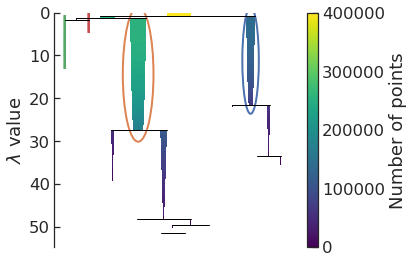

In [30]:
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
hdb.condensed_tree_.plot(select_clusters=True, \
                         selection_palette=sns.color_palette())
plt.tight_layout()

In [31]:
np.unique(hdb.labels_)

array([-1,  0,  1,  2,  3])

In order to be more stringent with the TBA methodology, let us set as 'noise' those points whose probability to be in their corresponding clusters is less than 30%.

In [32]:
for i in range(len(hdb.labels_)):
    if hdb.probabilities_[i] < 0.3:
        hdb.labels_[i] = -1

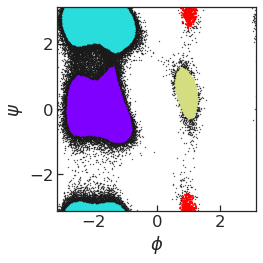

In [33]:
fig, ax = plt.subplots(figsize=(4,4))
assign = hdb.labels_ >= 0
ax.scatter(X[assign,0], X[assign,1], marker='o', 
                cmap='rainbow', s=1, c=hdb.labels_[assign])
nassign = hdb.labels_ == -1
ax.scatter(X[nassign,0], X[nassign,1], marker='.', 
                cmap='rainbow', s=0.5, c='k')
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')
plt.tight_layout()

Plot clusters projected onto backbone torsion angles along the trajectory to check if different regions are properly retrieved by HDBSCAN.

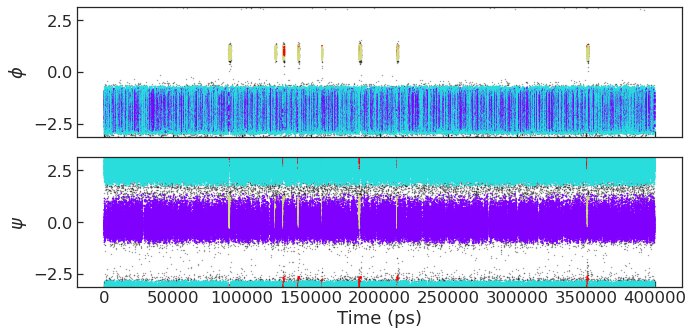

In [34]:
assign = hdb.labels_>= 0 
nassign = hdb.labels_ < 0

fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, sharey=True)
ax[0].scatter(np.arange(len(X[:,1]))[nassign], \
              X[nassign,0], s=0.15, c='k', alpha=0.5)
ax[0].scatter(np.arange(len(X[:,1]))[assign], \
              X[assign,0], s=0.5, cmap=cm.rainbow
        , c=hdb.labels_[assign])
ax[1].scatter(np.arange(len(X[:,1]))[nassign], \
              X[nassign,1], s=0.15, c='k', alpha=0.5)
ax[1].scatter(np.arange(len(X[:,1]))[assign], \
              X[assign,1], s=0.5, cmap=cm.rainbow
        , c=hdb.labels_[assign])
ax[0].set_ylabel('$\phi$')
ax[1].set_ylabel('$\psi$')
ax[1].set_xlabel('Time (ps)')
ax[1].set_ylim(-np.pi, np.pi)
plt.tight_layout()

Construct hdbMSM and corresponding plots (ITS, relaxation times and Chapman-Kolmogorov test).

In [35]:
labels_tba = []
for i, l in enumerate(hdb.labels_):
    if l == -1:
        try:
            labels_tba.append(labels_tba[-1])
        except IndexError:
            pass
    else:
        labels_tba.append(l)

In [36]:
lags = range(1,50,5)
its_hdb = msm.its(labels_tba, lags=lags, errors='bayes')

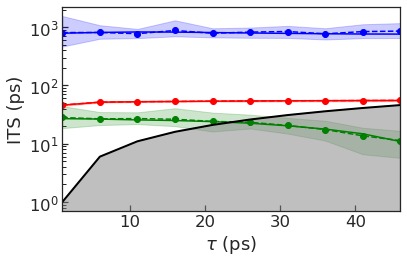

In [37]:
mplt.plot_implied_timescales(its_hdb, show_mean=True, nits=10, \
                             ylog=True, units='ps', dt=1)
plt.ylabel('ITS (ps)')
plt.xlabel(r'$\tau$ (ps)')
plt.tight_layout()

In [38]:
Mhdb = msm.bayesian_markov_model(labels_tba, 10, dt_traj='1 ps')

Note above that we estimate the MSM by excluding from the discrete trajectory those points that are considered 'noise', i.e. that do not belong to any HDBSCAN cluster.

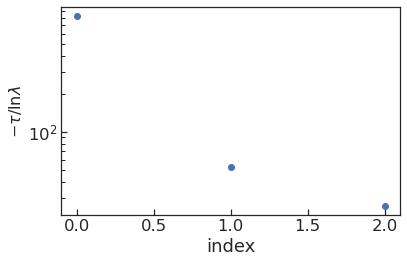

In [39]:
plt.plot(Mhdb.timescales(),linewidth=0,marker='o')
plt.xlabel('index')
plt.ylabel(r'$-\tau/\ln \lambda$', fontsize=16)
plt.yscale('log')
plt.tight_layout()

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')


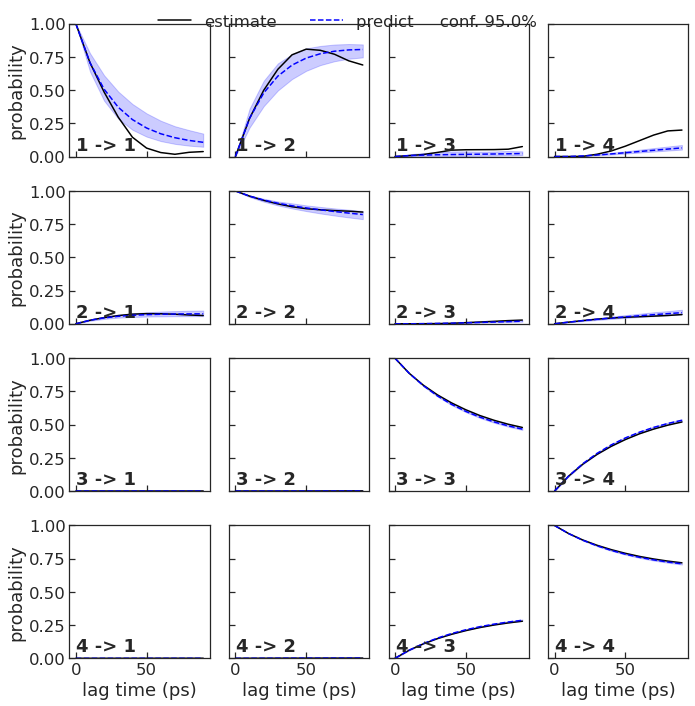

In [40]:
pyemma.plots.plot_cktest(Mhdb.cktest(4), units='ps', dt=1)
plt.tight_layout()

## Exploring parameter space

### Min cluster size

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


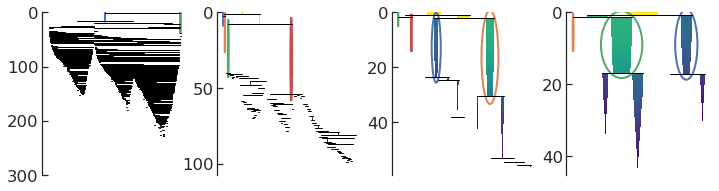

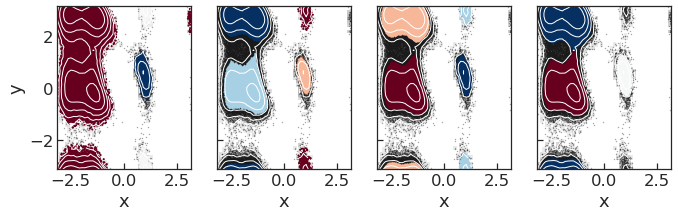

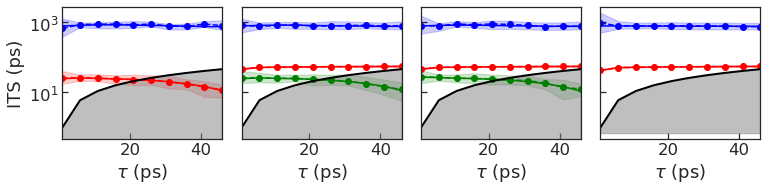

In [41]:
lags = range(1,50,5)
fig, ax = plt.subplots(1, 4, figsize=(12,3))
fig2, ax2 = plt.subplots(1,4, figsize=(11,3), sharex=True, sharey=True)
fig3, ax3 = plt.subplots(1,4, figsize=(11,3), sharex=True, sharey=True)

for i, mcs in enumerate([20, 100, 300, 500]):
    hdb = hdbscan.HDBSCAN(min_cluster_size=mcs).fit(Y)
    hdb.condensed_tree_.plot(select_clusters=True, colorbar=False, axis=ax[i], \
                             selection_palette=sns.color_palette()) #cmap='RdBu_r')
    ax[i].set_ylabel('')
  
    h, xedges, yedges, im = ax2[i].hist2d(X[:,0], X[:,1], bins=[np.linspace(-np.pi, np.pi, 50), \
        np.linspace(-np.pi, np.pi, 50)], cmap='binary', norm=mpl.colors.LogNorm(), density=True)
    CS = ax2[i].contour(-np.transpose(np.log(h)), extent=[xedges.min(), xedges.max(), yedges.min(), yedges.max()], \
                  linewidths=1,  colors='white')

    for j in range(len(hdb.labels_)):
        if hdb.probabilities_[j] < 0.3:
            hdb.labels_[j] = -1

    assign = hdb.labels_ >= 0
    ax2[i].scatter(X[assign,0],X[assign,1], marker='o', 
                cmap='RdBu', s=1, c=hdb.labels_[assign])
    nassign = hdb.labels_ == -1
    ax2[i].scatter(X[nassign,0],X[nassign,1], marker='.', 
                s=0.5, c='k', alpha=0.5)

    ax2[i].set_xlabel('x')
    
    labels_tba = []
    for k, l in enumerate(hdb.labels_):
        if l == -1:
            try:
                labels_tba.append(labels_tba[-1])
            except IndexError:
                pass
        else:
            labels_tba.append(l)

    its_hdb = msm.its(labels_tba, lags=lags, errors='bayes')
    
    mplt.plot_implied_timescales(its_hdb, ax=ax3[i], ylog=True)#ylog=True
    ax3[i].set_xlabel(r'$\tau$ (ps)', fontsize=18)
    ax3[i].set_ylabel('')

ax2[0].set_ylabel('y')
plt.tight_layout()

ax3[0].set_ylabel('ITS (ps)', fontsize=18)
plt.tight_layout()

### Min samples

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


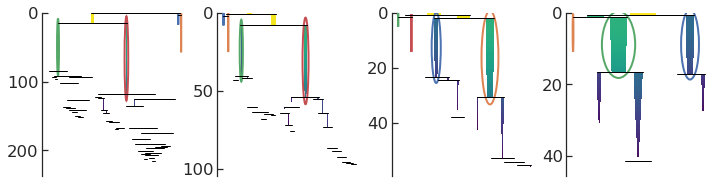

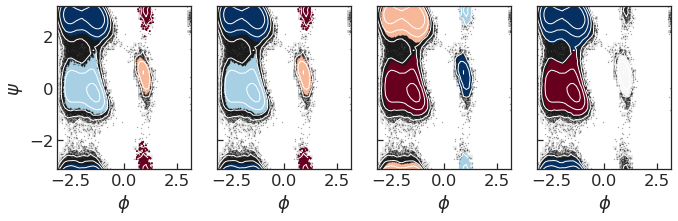

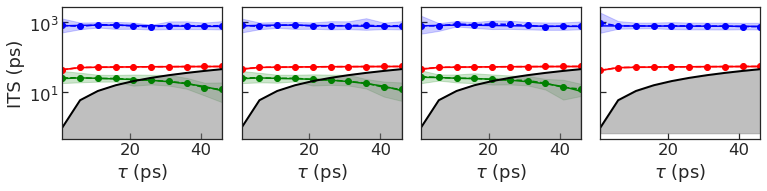

In [42]:
lags = range(1,50,5)
fig, ax = plt.subplots(1, 4, figsize=(12,3))
fig2, ax2 = plt.subplots(1,4, figsize=(11,3), sharex=True, sharey=True)
fig3, ax3 = plt.subplots(1,4, figsize=(11,3), sharex=True, sharey=True)
mcs = 350
for i, ms in enumerate([20, 100, 300, 500]):
    hdb = hdbscan.HDBSCAN(min_cluster_size=mcs,min_samples=ms).fit(Y)
    hdb.condensed_tree_.plot(select_clusters=True, colorbar=False, axis=ax[i], \
                             selection_palette=sns.color_palette()) #cmap='RdBu_r')
    ax[i].set_ylabel('')
  
    h, xedges, yedges, im = ax2[i].hist2d(X[:,0], X[:,1], bins=[np.linspace(-np.pi, np.pi, 50), \
        np.linspace(-np.pi, np.pi, 50)], cmap='binary', norm=mpl.colors.LogNorm(), density=True)
    CS = ax2[i].contour(-np.transpose(np.log(h)), extent=[xedges.min(), xedges.max(), yedges.min(), yedges.max()], \
                  linewidths=1,  colors='white')

    for j in range(len(hdb.labels_)):
        if hdb.probabilities_[j] < 0.3:
            hdb.labels_[j] = -1

    assign = hdb.labels_ >= 0
    ax2[i].scatter(X[assign,0],X[assign,1], marker='o', 
                cmap='RdBu', s=1, c=hdb.labels_[assign])
    nassign = hdb.labels_ == -1
    ax2[i].scatter(X[nassign,0],X[nassign,1], marker='.', 
                s=0.5, c='k', alpha=0.5)

    ax2[i].set_xlabel('$\phi$')
    
    labels_tba = []
    for k, l in enumerate(hdb.labels_):
        if l == -1:
            try:
                labels_tba.append(labels_tba[-1])
            except IndexError:
                pass
        else:
            labels_tba.append(l)

    its_hdb = msm.its(labels_tba, lags=lags, errors='bayes')
    
    mplt.plot_implied_timescales(its_hdb, ax=ax3[i], ylog=True)#ylog=True
    ax3[i].set_xlabel(r'$\tau$ (ps)', fontsize=18)
    ax3[i].set_ylabel('')

ax2[0].set_ylabel('$\psi$')
plt.tight_layout()

ax3[0].set_ylabel('ITS (ps)', fontsize=18)
plt.tight_layout()

### Soft clustering

In [43]:
hdb = hdbscan.HDBSCAN(min_cluster_size=350).fit(Y)
import copy

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


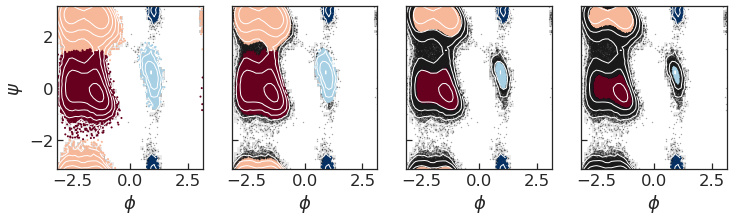

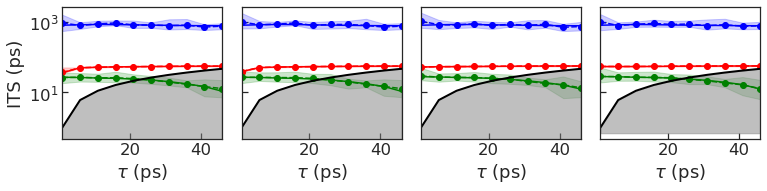

In [44]:
fig, ax = plt.subplots(1,4, figsize=(12, 3.), sharex=True, sharey=True)
fig2, ax2 = plt.subplots(1,4, figsize=(11,3), sharex=True, sharey=True)

for j, pc in enumerate([0.0, 0.2, 0.5, 0.7]):
    hdb_copy = copy.deepcopy(hdb)
    for i, x_i in enumerate(hdb_copy.labels_):
        if hdb_copy.probabilities_[i] < pc:
            hdb_copy.labels_[i] = -1

    assign = hdb_copy.labels_ >= 0

    h, xedges, yedges, im = ax[j].hist2d(X[:,0], X[:,1], bins=[np.linspace(-np.pi, np.pi, 50), \
        np.linspace(-np.pi, np.pi, 50)], cmap='binary', norm=mpl.colors.LogNorm(), density=True)
    CS = ax[j].contour(-np.transpose(np.log(h)), extent=[xedges.min(), xedges.max(), yedges.min(), yedges.max()], \
                  linewidths=1,  colors='white')  

    ax[j].scatter(X[assign,0],X[assign,1], marker='o', 
                cmap='RdBu', s=1, c=hdb_copy.labels_[assign])
    nassign = hdb_copy.labels_ == -1
    ax[j].scatter(X[nassign,0],X[nassign,1], marker='.', 
                s=0.5, c='k', alpha=0.5)

    ax[j].set_xlabel('$\phi$')
    
    
    labels_tba = []
    for i, l in enumerate(hdb_copy.labels_):
        if l == -1:
            try:
                labels_tba.append(labels_tba[-1])
            except IndexError:
                pass
        else:
            labels_tba.append(l)

    its_hdb = msm.its(labels_tba, lags=lags, errors='bayes')
    
    mplt.plot_implied_timescales(its_hdb, ax=ax2[j], ylog=True)#ylog=True
    ax2[j].set_xlabel(r'$\tau$ (ps)', fontsize=18)
    ax2[j].set_ylabel('')
ax2[0].set_ylabel('ITS (ps)', fontsize=18)

plt.tight_layout()
    
ax[0].set_ylabel('$\psi$')
plt.tight_layout()

### pfold and clusters

Finally, compute pfold function from the reference fine-grained MSM and compare with the clusters obtained by the best hdbMSM (which is recalculated below). HDBSCAN clusters should recapitulate flat pfold regions. To compute pfold, eigenvectors from the fine-grained MSM are used so that two main sets are divided.

In [45]:
hdb = hdbscan.HDBSCAN(min_cluster_size=350).fit(Y)

In [46]:
for i in range(len(hdb.labels_)):
    if hdb.probabilities_[i] < 0.3:
        hdb.labels_[i] = -1

In [47]:
A = [i for i, x in enumerate(eigvec[2]) if (x>0.007)] #0.006
B = [i for i, x in enumerate(eigvec[2]) if (x<-0.005)] #-0.005
C = [i for i, x in enumerate(eigvec[3]) if (x>0.008)]
D = [i for i, x in enumerate(eigvec[1]) if (x<-0.01)]
A = A + C + D
B = B

In [48]:
flux = pyemma.msm.tpt(M, A, B)

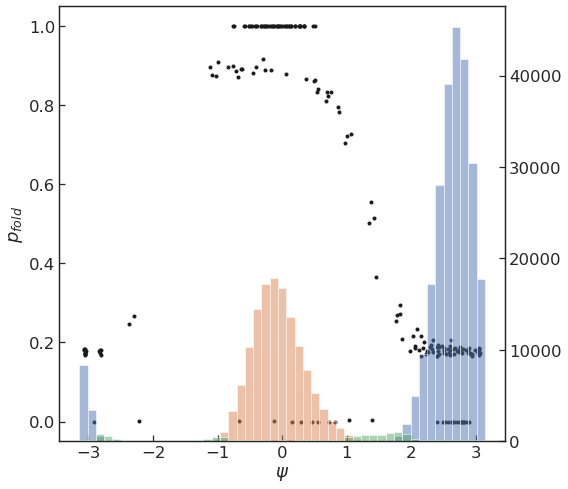

In [49]:
fig, ax = plt.subplots(figsize=(8,8))
axt = ax.twinx()
axt.hist(X[hdb.labels_==1, 1], bins=np.linspace(-np.pi, np.pi, 50), alpha=0.5)
axt.hist(X[hdb.labels_==0, 1], bins= np.linspace(-np.pi, np.pi, 50), alpha=0.5)
axt.hist(X[hdb.labels_==-1, 1], bins=np.linspace(-np.pi, np.pi, 50), alpha=0.5)
ax.plot(kmeans.clustercenters[:,1], flux.committor, '.', color='k')
ax.set_xlabel('$\psi$')
ax.set_ylabel(r'$p_{fold}$')
sns.set_context('paper', font_scale=1.8)

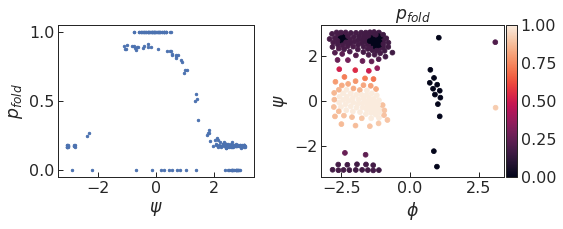

In [50]:
fig, ax = plt.subplots(1,2,figsize=(8,3.5))
ax[0].plot(kmeans.clustercenters[:,1], flux.committor, '.')
#ax.set_xlim(-6.5,6.5)
ax[0].set_xlabel('$\psi$')
ax[0].set_ylabel(r'$p_{fold}$')
sc = ax[1].scatter(kmeans.clustercenters[:,0],kmeans.clustercenters[:,1],c=flux.committor)
ax[1].set_xlabel('$\phi$')
ax[1].set_ylabel('$\psi$')
ax[1].set_title(r'$p_{fold}$')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='6%', pad=0.03)
fig.colorbar(sc, cax=cax, orientation='vertical')
plt.tight_layout()

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


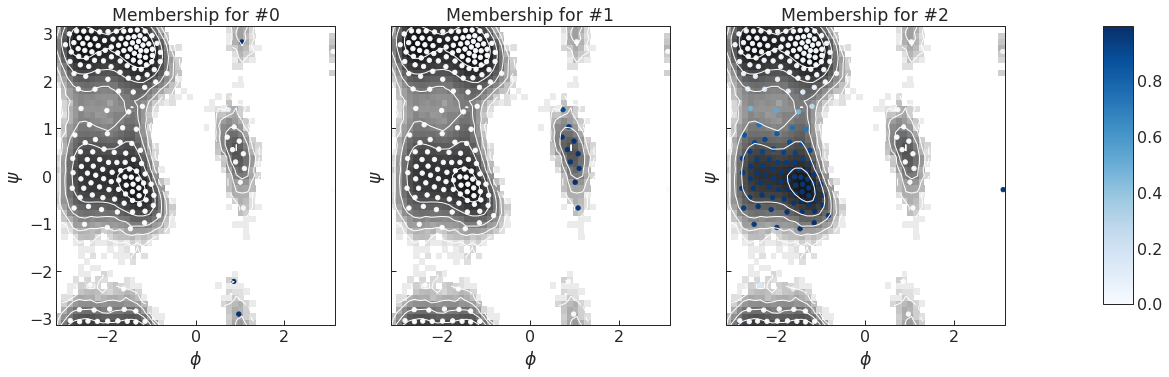

In [51]:
pcca = M.pcca(4)
X = feat.transform(traj)
fig, ax = plt.subplots(1, 3, figsize=(17, 5.5), sharex=True, sharey=True)
for i in range(3):
    h, xedges, yedges, im = ax[i].hist2d(X[:,0], X[:,1], \
        bins=[np.linspace(-np.pi, np.pi, 50),  \
              np.linspace(-np.pi, np.pi, 50)], \
        cmap='binary', norm=mpl.colors.LogNorm(), density=True)
    CS = ax[i].contour(-np.transpose(np.log(h)), extent=[xedges.min(), xedges.max(), yedges.min(), yedges.max()], \
                  linewidths=1,  colors='white')
ax[0].set_title('Membership for #0')
ax[1].set_title('Membership for #1')
ax[2].set_title('Membership for #2')
im = ax[0].scatter(kmeans.clustercenters[:,0],kmeans.clustercenters[:,1],\
                   c=pcca.memberships[:,0], s=20, cmap='Blues')
im = ax[1].scatter(kmeans.clustercenters[:,0],kmeans.clustercenters[:,1],\
                   c=pcca.memberships[:,1], s=20, cmap='Blues')
im = ax[2].scatter(kmeans.clustercenters[:,0],kmeans.clustercenters[:,1],\
                   c=pcca.memberships[:,2], s=20, cmap='Blues')
cbar_ax = fig.add_axes([0.98, 0.18, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax, orientation='vertical',fraction=0.1)
ax[0].set_xlabel('$\phi$')
ax[0].set_ylabel('$\psi$')
ax[1].set_xlabel('$\phi$')
ax[1].set_ylabel('$\psi$')
ax[2].set_xlabel('$\phi$')
ax[2].set_ylabel('$\psi$')
#plt.tight_layout()
sns.set_context('paper', font_scale=1.9)